In [1]:
import numpy as np
import pandas as pd
import h5py
import pysam
import os
from modisco.visualization import viz_sequence
from modisco import util
from matplotlib import pyplot as plt
import pybedtools
from bs4 import BeautifulSoup

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [8]:
dttype = 'ATAC'
mode = "profile"
celltype="K562"
modisco_path = '/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/DNASE/'+celltype+'/merge_folds_new/'+mode+'/modisco_old_format.h5'
ppm_dir = ''

htmld="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/"+dttype+'/'+celltype+"/merge_folds_new/"+mode+"/motifs.html"
tomtom = pd.read_html(htmld)


background=[0.25, 0.25, 0.25, 0.25]

In [9]:
def trim_motif_new(cwm, motif, trim_threshold=0.20):
    """
    Given the PFM and motif (both L x 4 arrays) (the motif could be the
    PFM itself), trims `motif` by cutting off flanks of low information
    content in `pfm`. `min_ic` is the minimum required information
    content. If specified this trimmed motif will be extended on either
    side by `pad` bases.
    If no base passes the `min_ic` threshold, then no trimming is done.
    """
    
    score = np.sum(np.abs(cwm), axis=1)
    trim_thresh = np.max(score) * trim_threshold  # Cut off anything less than 30% of max score
    pass_inds = np.where(score >= trim_thresh)[0]
    trimmed = motif[np.min(pass_inds): np.max(pass_inds) + 1]
 
    if not trimmed.size:
        return motif
    
    return trimmed

def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            print(len(metacluster["seqlets"].value))
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name
                pattern = patterns[pattern_name]
                if metacluster_i==0:
                    key = "pos_patterns.pattern_"+str(pattern_i)
                if metacluster_i==1:
                    key = "neg_patterns.pattern_"+str(pattern_i)                
                
                if key not in pfms:
                    pfms[key] = []

                for seqlet in pattern["seqlets_and_alnmts"]["seqlets"]:
                    pfms[key].append(seqlet)
               
    return pfms


In [10]:
pfms = import_tfmodisco_motifs(modisco_path, trim=False)

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


217529
1585


In [11]:
bed="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/"+dttype+'/'+celltype+"/merge_folds_new/in_peaks.interpreted_regions.bed"
bed = pd.read_csv(bed, sep="\t", header=None)
bed.head()
print(bed.shape)

(269719, 11)


In [27]:
lists=[]
for seqlet in pfms["pos_patterns.pattern_25"]:
    vals = seqlet.split(",")
    peak_id = int(vals[0].split(":")[1])
    ss = vals[1].split(":")[1]
    ee = vals[2].split(":")[1]
    blist = [bed.loc[peak_id,0], bed.loc[peak_id,1]+bed.loc[peak_id,9]-250+int(ss), bed.loc[peak_id,1]+bed.loc[peak_id,9]-250+int(ee)]
    lists.append(blist)


In [28]:
#lists

In [29]:
import pyBigWig as pb
import numpy as np

In [30]:
counts_bw = pb.open("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/"+celltype+"/merge_folds_new/"+celltype+"_folds_merged.counts_scores.bw")
profile_bw = pb.open("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/"+celltype+"/merge_folds_new/"+celltype+"_folds_merged.profile_scores.bw")     

In [31]:
dn_counts_bw = pb.open("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/DNASE/"+celltype+"/merge_folds_new/"+celltype+"_folds_merged.counts_scores.bw")
dn_profile_bw = pb.open("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/DNASE/"+celltype+"/merge_folds_new/"+celltype+"_folds_merged.profile_scores.bw")     

In [32]:
counts_tot = []
profile_tot = []
for val in lists:
    counts_tot.append(np.sum(np.nan_to_num(counts_bw.values(val[0], val[1], val[2]))))
    profile_tot.append(np.sum(np.nan_to_num(profile_bw.values(val[0], val[1], val[2]))))

In [33]:
dn_counts_tot = []
dn_profile_tot = []
for val in lists:
    dn_counts_tot.append(np.sum(np.nan_to_num(dn_counts_bw.values(val[0], val[1], val[2]))))
    dn_profile_tot.append(np.sum(np.nan_to_num(dn_profile_bw.values(val[0], val[1], val[2]))))

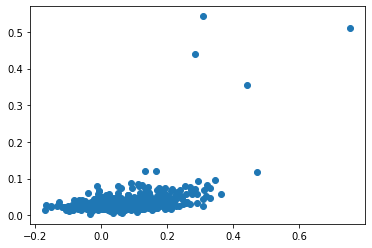

In [34]:
import matplotlib.pyplot as plt
plt.scatter(counts_tot, profile_tot)


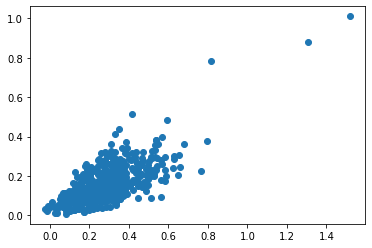

In [35]:
plt.scatter(dn_counts_tot, dn_profile_tot)


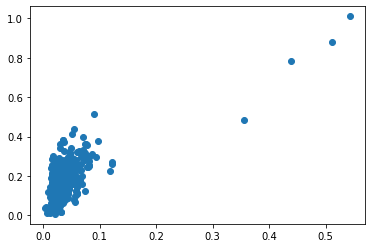

In [36]:
plt.scatter(profile_tot, dn_profile_tot)


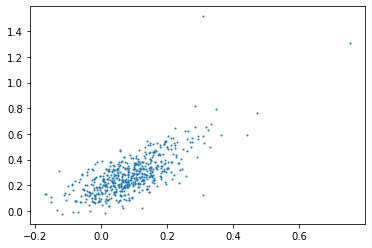

In [39]:
plt.scatter(counts_tot, dn_counts_tot, s=1)


In [ ]:
# dataf = open("zeb_pos_regions.bed", "w")
# for val in lists:
#     dataf.write("\t".join(map(str,val)))
#     dataf.write("\n")
# dataf.close()

In [ ]:
# dn_bed=pd.read_csv("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/DNASE/IMR90/merge_folds_new/in_peaks.interpreted_regions.bed", sep='\t', header=None)


In [ ]:
# dn_bed["st"] = dn_bed[1]+dn_bed[9]-250
# dn_bed["end"] = dn_bed["st"]+500

In [ ]:
# dn_bed[[0, "st", "end"]].to_csv("temp_dnase.bed",sep="\t", header=False, index=False)